In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import natsort
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version =",tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

tf version = 2.2.0-dev20200501


## Import data

In [2]:
pickle_in = open('ESOL_random.pickle','rb')
data = pickle.load(pickle_in)
data.head()

Compound ID  ESOL predicted log solubility in mols per litre  \
164                RTI 3                                           -3.049   
907           2,4',5-PCB                                           -5.762   
386        aminothiazole                                           -1.226   
221   2,4-Dinitrotoluene                                           -2.604   
1069     o-Methoxyphenol                                           -1.941   

      Minimum Degree  Molecular Weight  Number of H-Bond Donors  \
164                1           255.277                        1   
907                1           257.547                        0   
386                1           100.146                        1   
221                1           182.135                        0   
1069               1           124.139                        1   

      Number of Rings  Number of Rotatable Bonds  Polar Surface Area  \
164                 3                          0               68.45   
907                 2                          1                0.00   
386                 1                          0               38.91   
221                 1                          2               86.28   
1069                1                          1               29.46   

      measured log solubility in mols per litre  \
164                                      -3.043   
907                                      -6.250   
386                                      -0.360   
221                                      -2.820   
1069                                     -1.960   

                                   smiles  
164   O2c1cc(C)ccc1N(C)C(=O)c3cc(N)cnc23   
907           Clc1ccc(cc1)c2cc(Cl)ccc2Cl   
386                             Nc1nccs1   
221             Cc1ccc(cc1N(=O)=O)N(=O)=O  
1069                          COc1ccccc1O

## Convert Smiles to Images
- Smile is converted into image(80x80 px) and saved as [iname].png in [path]
- while loop loops over all smiles in table

In [3]:
n = 0
n_max = data.shape[0]

while n < n_max:
    
    smi = data.iloc[n,9]

    size = (56,56)
    ipath = "ESOL_img/" + str(n) + ".png"

    mol = Chem.MolFromSmiles(smi)

    Draw.MolToImageFile(mol,ipath,size = size)
    
    n += 1


## Preprocess generated images

In [4]:
filename = natsort.natsorted(glob.glob("ESOL_img/*.png"))

img_list = [cv2.imread(file) for file in filename]


gimg_list = []
for img in img_list:
    gimg_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))    #list is converted to gray img's
    

for f in filename:      # delets images after converting them to array
    os.remove(f)

### Generate three arrays
- gimg_array = features
- Name = Compound ID
- comp_sol = log(sol) of compound

In [5]:
comp_sol = np.array(data["measured log solubility in mols per litre"].tolist())
gimg_array = (np.array(gimg_list)/255)
name = np.array(data["Compound ID"].tolist())


## Test if labels are linked in correct way

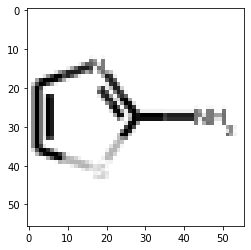

aminothiazole
-0.36


In [6]:
t = 2

plt.imshow(gimg_array[t], cmap = "gray")
plt.show()

print(name[t])
print(comp_sol[t])

## Generate training_data and test_data:

In [7]:
X_full = gimg_array.reshape(-1, size[0], size[1],1)
y_full = comp_sol

s = 0.9  #size in percent of training data from full data

train_size =round(len(X_full)*s)


X_train = X_full[:train_size]
X_test = X_full[train_size:]
y_train = y_full[:train_size]
y_test = y_full[train_size:]


print("X_train:",len(X_train),X_train.shape)
print("X_test:",len(X_test),X_test.shape)
print("y_train:",len(y_train))
print("y_test:",len(y_test))



X_train: 1015 (1015, 56, 56, 1)
X_test: 113 (113, 56, 56, 1)
y_train: 1015
y_test: 113


In [8]:
#pickle_out = open('ESOL_full_28x28_X.pickle', 'wb')
#pickle.dump(X_full, pickle_out)
#pickle_out.close()

#pickle_out = open('ESOL_full_y.pickle','wb')
#pickle.dump(y_full, pickle_out)
#pickle_out.close()

## Fine tuning all in one

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 43265     
Total params: 48,209
Trainable params: 48,209
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
28/29 [===========================>..] - ETA: 0s - loss: 6.0408 - mae: 1.9633 - mse: 6.0408
Epoch: 0, loss:5.9999,  mae:1.9526,  mse:5.9999,  val_loss:4.4026,  val_mae:1.6440,  val_mse:4.4026,  
29/29 [==============================] 

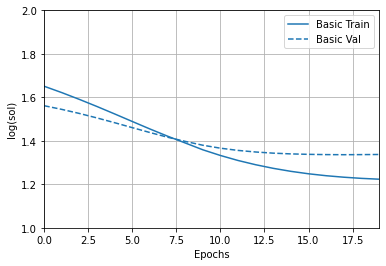

4/4 - 0s - loss: 3.2259 - mae: 1.4280 - mse: 3.2259
Testing set Mean Abs Error: +/-  1.43 mol/l


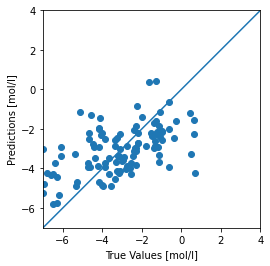

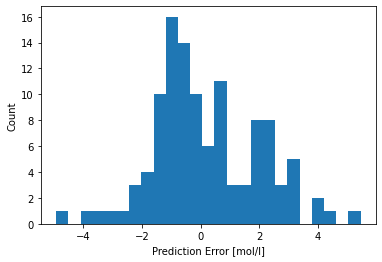

In [9]:
def build_model():
  model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(1)
  ])
  
  

  optimizer = tf.keras.optimizers.Adam(0.0001)


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


model = build_model()

print(model.summary())

EPOCHS = 20

history = model.fit(
  X_train, y_train,
  epochs = EPOCHS, validation_split = 0.1, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])


plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([1, 2])
plt.ylabel('log(sol)')
plt.show()

loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: +/- {:5.2f} mol/l".format(mae))

test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mol/l]')
plt.ylabel('Predictions [mol/l]')
lims = [-7, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [mol/l]")
_ = plt.ylabel("Count")

plt.show()